In [198]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [199]:
R = 2
angle = np.linspace(0.0, 2.0 * np.pi, 256)

In [200]:
x = R * np.cos(angle)
y = R * np.sin(angle)

n_theta = 5
dtheta = np.pi / n_theta
theta = np.arange(-np.pi/2, np.pi/2, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta_alt = np.arange(-np.pi/2 + dtheta, np.pi/2 + dtheta, dtheta)

In [201]:
def vec_angle(vec):
    x = vec[0]
    y = vec[1]
    if x > 0:
        return np.arctan(y / x)
    if x < 0 and y >= 0:
        return np.arctan(y / x) + np.pi
    if x < 0 and y < 0:
        return np.arctan(y / x) - np.pi
    if x == 0 and y > 0:
        return np.pi/2
    if x == 0 and y < 0:
        return -np.pi/2        

k3 A: 	1.1071487177940904
k1 A: 	0.5404195002705842
k2: 	2.394580435827234
mid: 2.394580435827234
match: 	True
mid mod: 	-0.7470122177625598
mod match: 	True



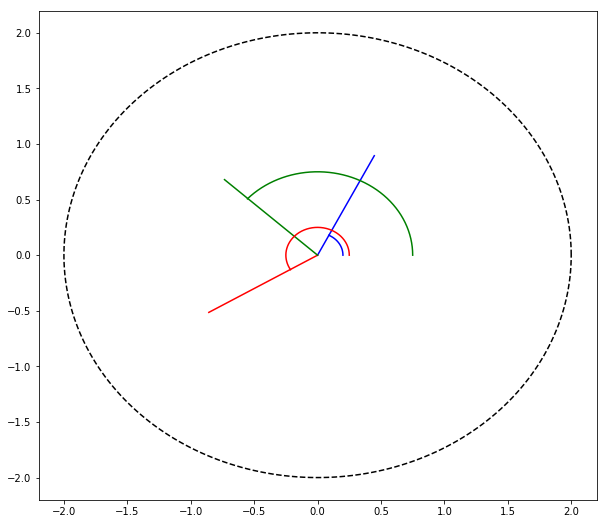

In [202]:
# %matplotlib widget

plt.figure(figsize = (10, 9))
plt.plot(x, y, 'k--')
# for t, t2, t3 in zip(theta, mid_theta, theta_alt):
#     plt.plot([0, R * np.cos(t)], [0, R * np.sin(t)], 'r--')
#     plt.plot([0, R * np.cos(t2)], [0, R * np.sin(t2)], 'b--')
#     plt.plot([0, R * np.cos(t3)], [0, R * np.sin(t3)], 'c')
k3 = np.array([32, 64])
k3 = k3/np.linalg.norm(k3)
k1 = np.array([40, 24])
k1 = k1/np.linalg.norm(k1)
k2 = k3 - k1
k2 =  k2 / np.linalg.norm(k2)
plt.plot([0, k3[0]], [0, k3[1]], 'b')
plt.plot([0, -k1[0]], [0, -k1[1]], 'r')
plt.plot([0, k2[0]], [0, k2[1]], 'g')
print("k3 A: \t{}\nk1 A: \t{}\nk2: \t{}\nmid: {}\nmatch: \t{}\nmid mod: \t{}\nmod match: \t{}".format(vec_angle(k3), 
                                                                                                      vec_angle(k1), 
                                                                                                      vec_angle(k2), 
                                                                                                      (vec_angle(k3) + vec_angle(k1) + np.pi)/2, 
                                                                                                      np.isclose(vec_angle(k2), (vec_angle(k3) + vec_angle(k1) + np.pi)/2), 
                                                                                                      np.mod((vec_angle(k3) + vec_angle(k1) + np.pi)/2+ 2.0 * np.pi, 2.0 * np.pi) - np.pi, 
                                                                                                      np.isclose(vec_angle(k2), np.mod((vec_angle(k3) + vec_angle(k1) + np.pi)/2 + 2.0 * np.pi, 2.0 * np.pi))))

print()

k3a = np.arange(0.0, vec_angle(k3) + 0.01, 0.01)
k1a = np.arange(0.0, vec_angle(k1) + np.pi + 0.01, 0.01)
k2a = np.arange(0.0, vec_angle(k2) + 0.01, 0.01)
plt.plot(0.2 * np.cos(k3a), 0.2 * np.sin(k3a), 'b')
plt.plot(0.25 * np.cos(k1a), 0.25 * np.sin(k1a), 'r')
plt.plot(0.75 * np.cos(k2a), 0.75 * np.sin(k2a), 'g')


plt.show()

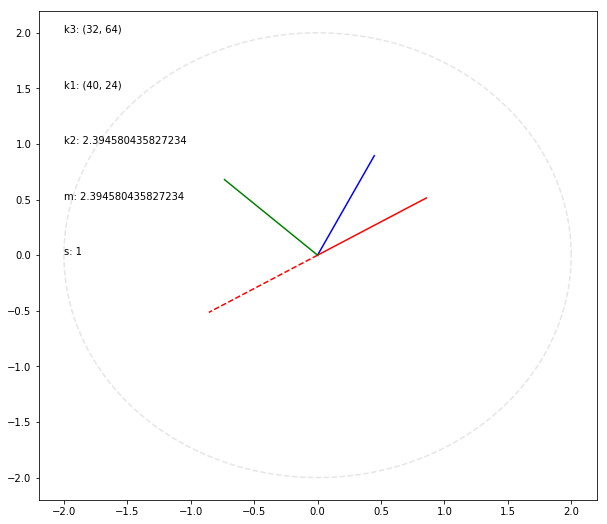

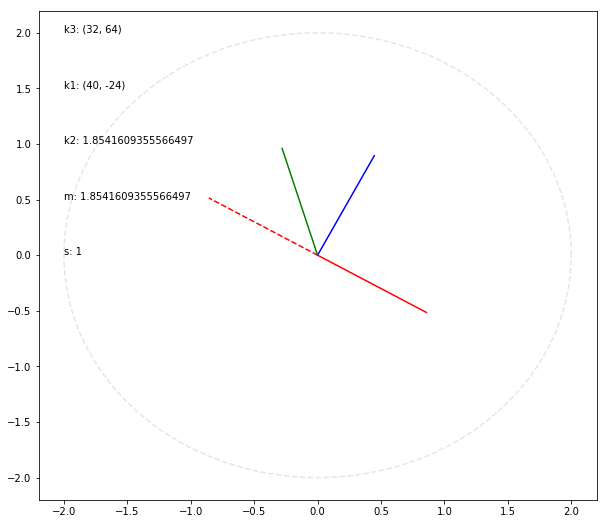

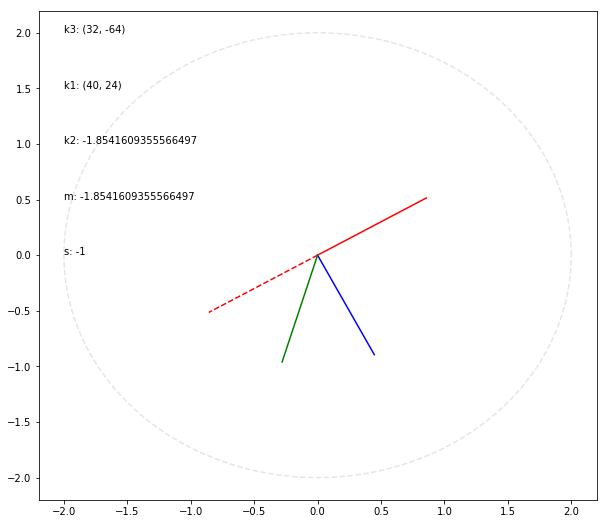

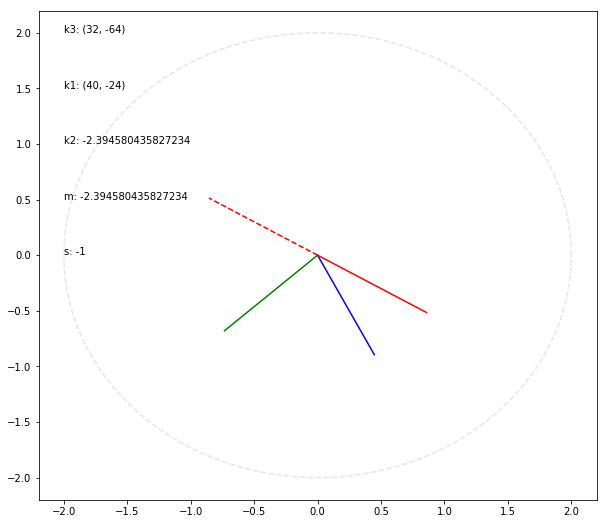

In [203]:
k3x_l = [32]
k3y_l = [64, -64]
k1x_l = [40]
k1y_l = [24, -24]

for k3x in k3x_l:
    for k3y in k3y_l:
        k3 = np.array([k3x, k3y])
        k3 = k3/np.linalg.norm(k3)
        for k1x in k1x_l:
            for k1y in k1y_l:
                k1 = np.array([k1x, k1y])
                k1 = k1/np.linalg.norm(k1)
                k2 = k3 - k1
                k2x = k2[0]
                k2y = k2[1]
                pre_fac = k1x*k3y - k3x*k1y
                k2 =  k2 / np.linalg.norm(k2)
                plt.figure(figsize = (10, 9))
                plt.plot(x, y, 'k--', alpha = 0.1)
                plt.plot([0, k3[0]], [0, k3[1]], 'b')
                plt.plot([0, k1[0]], [0, k1[1]], 'r')
                plt.plot([0, -k1[0]], [0, -k1[1]], 'r--')
                plt.plot([0, k2[0]], [0, k2[1]], 'g')
                plt.text(x = -2, y = 2, s =  "k3: ({}, {})".format(k3x, k3y))
                plt.text(x = -2, y = 1.5, s =  "k1: ({}, {})".format(k1x, k1y))
                plt.text(x = -2, y = 1, s =  "k2: {}".format(vec_angle(k2)))
                plt.text(x = -2, y = 0.5, s = "m: {}".format((vec_angle(k3) + vec_angle(k1) + np.sign(k1x*k2y - k2x*k1y)*np.pi)/2))
                plt.text(x = -2, y = 0.0, s = "s: {}".format(np.sign(pre_fac)))
                
                plt.show()

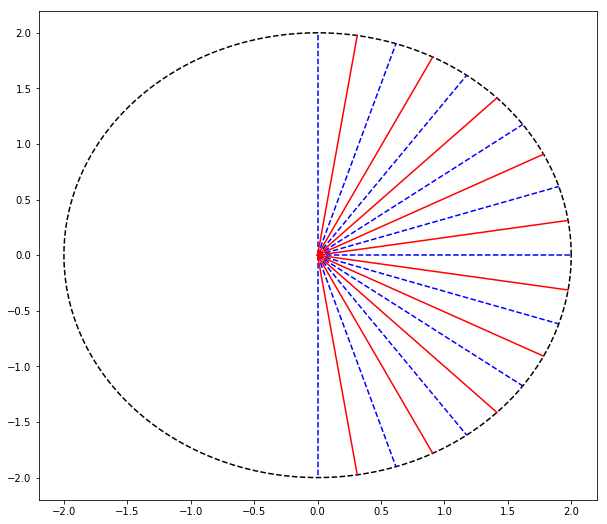

In [204]:
n_theta   = 10
dtheta    = np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5

plt.figure(figsize = (10, 9))
plt.plot(x, y, 'k--')
for a in range(theta.shape[0]):
    plt.plot([0, R*np.cos(theta[a])], [0, R*np.sin(theta[a])], 'b--')
for a in range(mid_theta.shape[0]):
    plt.plot([0, R*np.cos(mid_theta[a])], [0, R*np.sin(mid_theta[a])], 'r')

ml: -1.5707963267948966	k2a: -0.962933938534893	k2a: 2.1786587150549	mr: -0.9424777960769379	k: True	-k: False

ml: -0.9424777960769379	k2a: -0.42251443826430896	k2a: 2.719078215325484	mr: -0.3141592653589793	k: True	-k: False

ml: 0.3141592653589793	k2a: 0.42251443826430896	k2a: -2.719078215325484	mr: 0.9424777960769379	k: True	-k: False

ml: 0.3141592653589793	k2a: -2.5337302653297895	k2a: 0.6078623882600038	mr: 0.9424777960769379	k: False	-k: True

ml: 0.9424777960769379	k2a: 0.962933938534893	k2a: -2.1786587150549	mr: 1.5707963267948966	k: True	-k: False

ml: 0.9424777960769379	k2a: -1.9933107650592052	k2a: 1.1482818885305879	mr: 1.5707963267948966	k: False	-k: True

ml: -1.5707963267948966	k2a: -0.962933938534893	k2a: 2.1786587150549	mr: -0.9424777960769379	k: True	-k: False



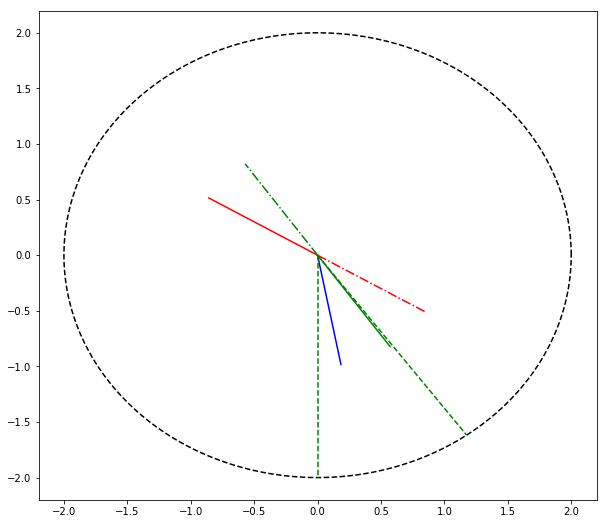

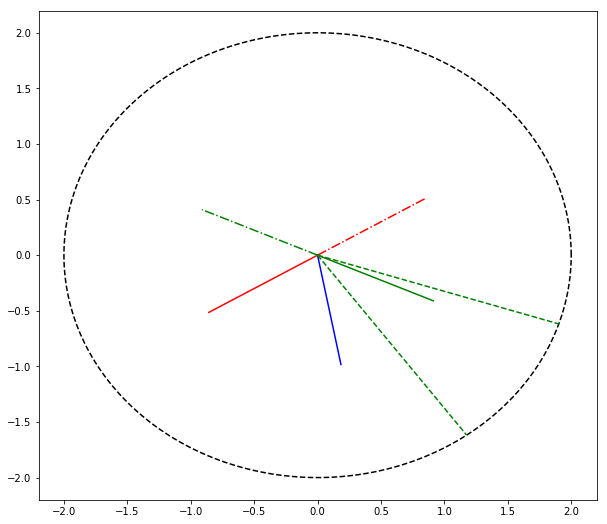

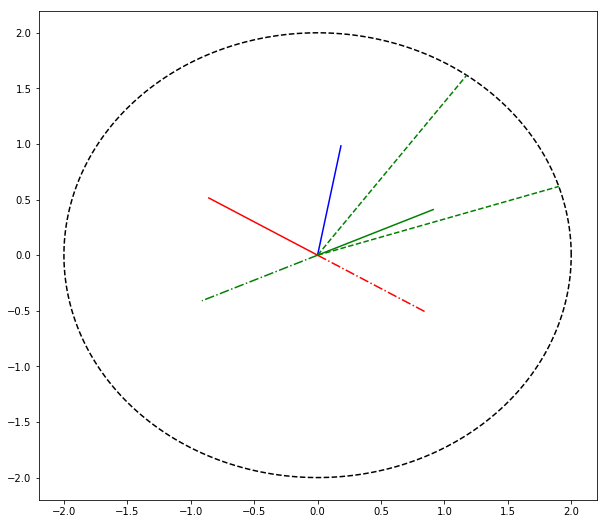

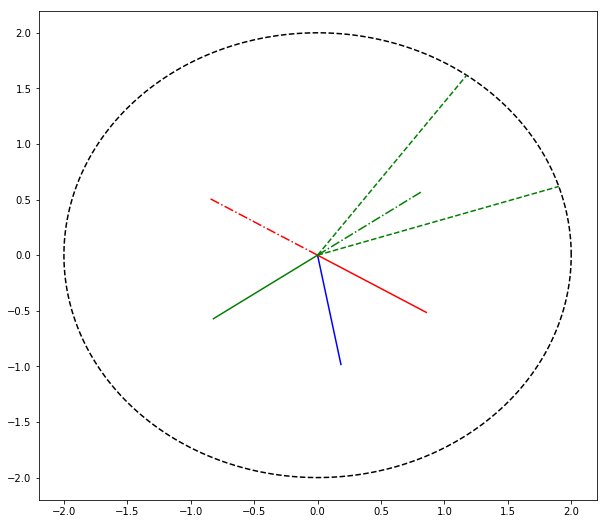

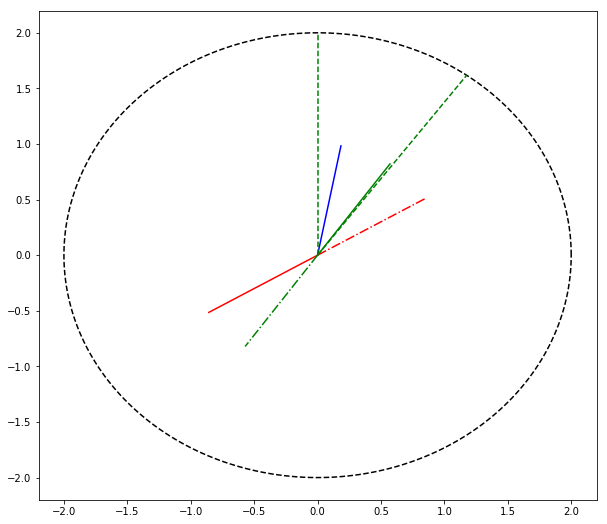

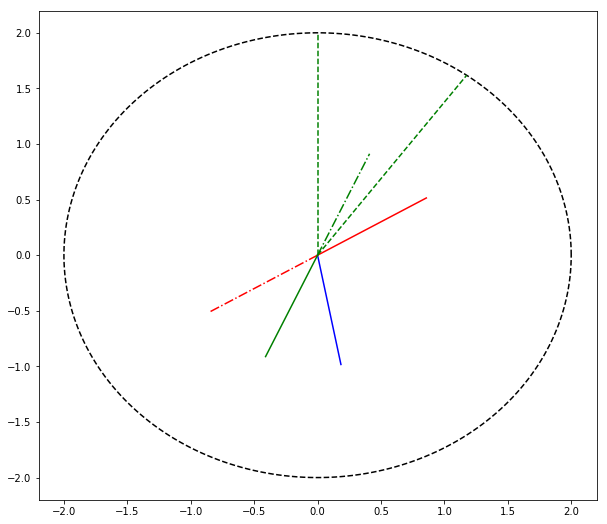

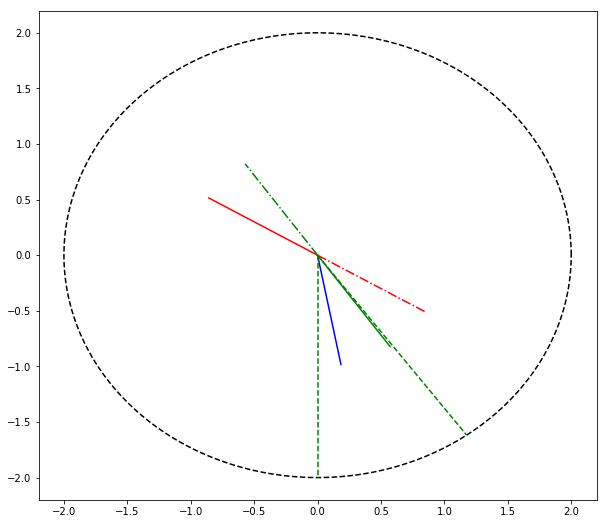

In [205]:
k3x_l = [12]
k3y_l = [64, -64]
k1x_l = [40, -40]
k1y_l = [24, -24]

n_theta   = 5
dtheta    = np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5

for a in range(theta.shape[0]):
    l = 4
#     for l in range(mid_theta.shape[0]):   
    for k3x in k3x_l:
        for k3y in k3y_l:
            k3 = np.array([k3x, k3y])
            k3 = k3/np.linalg.norm(k3)
            for k1x in k1x_l:
                for k1y in k1y_l:
                    k1 = np.array([k1x, k1y])
                    k1 = k1/np.linalg.norm(k1)
                    k2 = k3 - k1
                    k2x = k2[0]
                    k2y = k2[1]
                    pre_fac = k1x*k2y - k2x*k1y
                    k2 =  k2 / np.linalg.norm(k2)
                    if (mid_theta[np.mod(a, n_theta)] - dtheta/2 <= vec_angle(k2) < mid_theta[np.mod(a, n_theta)] + dtheta/2) or (k2y < 0 and (mid_theta[np.mod(a, n_theta)] - dtheta/2 <= vec_angle(-k2) < mid_theta[np.mod(a, n_theta)] + dtheta/2)):
                        print("ml: {}\tk2a: {}\tk2a: {}\tmr: {}\tk: {}\t-k: {}\n".format(mid_theta[np.mod(a, n_theta)] - dtheta/2, vec_angle(k2), vec_angle(-k2), mid_theta[np.mod(a, n_theta)] + dtheta/2,
                                                                                        (mid_theta[np.mod(a, n_theta)] - dtheta/2 <= vec_angle(k2) < mid_theta[np.mod(a, n_theta)] + dtheta/2),
                                                                                        (mid_theta[np.mod(a, n_theta)] - dtheta/2 <= vec_angle(-k2) < mid_theta[np.mod(a, n_theta)] + dtheta/2)))
                        plt.figure(figsize = (10, 9))
                        plt.plot(x, y, 'k--')
                        plt.plot([0, k3[0]], [0, k3[1]], 'b')
                        plt.plot([0, k1[0]], [0, k1[1]], 'r')
                        plt.plot([0, -k1[0]], [0, -k1[1]], 'r-.')
                        plt.plot([0, k2[0]], [0, k2[1]], 'g')
                        plt.plot([0, -k2[0]], [0, -k2[1]], 'g-.')
                        plt.plot([0, R*np.cos(mid_theta[np.mod(a, n_theta)] - dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a, n_theta)] - dtheta/2)], 'g--')
                        plt.plot([0, R*np.cos(mid_theta[np.mod(a, n_theta)] + dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a, n_theta)] + dtheta/2)], 'g--')
                        
#                         plt.plot([0, R*np.cos(mid_theta[np.mod(a + l, n_theta)] - dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a + l, n_theta)] - dtheta/2)], 'b--')
#                         plt.plot([0, R*np.cos(mid_theta[np.mod(a + l, n_theta)] + dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a + l, n_theta)] + dtheta/2)], 'b--')
#                     if vec_angle(k2) >= mid_theta[np.mod(a + l, n_theta)] - dtheta/2 and vec_angle(k2) < mid_theta[np.mod(a + l, n_theta)] + dtheta/2:
#                         plt.figure(figsize = (10, 9))
#                         plt.plot(x, y, 'k--')
#                         plt.plot([0, R*np.cos(theta[a])], [0, R*np.sin(theta[a])], 'b--')
#                         plt.plot([0, R*np.cos(theta[a + 1])], [0, R*np.sin(theta[a + 1])], 'b--')
#                         plt.plot([0, R*np.cos(mid_theta[np.mod(a + l, n_theta)] - dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a + l, n_theta)] - dtheta/2)], 'r--')
#                         plt.plot([0, R*np.cos(mid_theta[np.mod(a + l, n_theta)] + dtheta/2)], [0, R*np.sin(mid_theta[np.mod(a + l, n_theta)] + dtheta/2)], 'r--')

#                         plt.plot([0, k3[0]], [0, k3[1]], 'b')
#                         plt.plot([0, k1[0]], [0, k1[1]], 'r')
#                         plt.plot([0, -k1[0]], [0, -k1[1]], 'r--')
#                         plt.plot([0, k2[0]], [0, k2[1]], 'g')
#                         plt.text(x = -2, y = 2, s =  "k3: ({}, {})".format(k3x, k3y))
#                         plt.text(x = -2, y = 1.5, s =  "k1: ({}, {})".format(k1x, k1y))
#                         plt.text(x = -2, y = 1, s =  "k2: {}".format(vec_angle(k2)))
#                         plt.text(x = -2, y = 0.5, s = "m: {}".format((vec_angle(k3) + vec_angle(k1) + np.sign(k1x*k2y - k2x*k1y)*np.pi)/2))
#                         plt.text(x = -2, y = 0.0, s = "s: {}".format(np.sign(pre_fac)))

#                         plt.show()           

In [225]:
def plot_triad_wave_vec(k3_vec, k1_vec):
    k3x = k3_vec[0]
    k3y = k3_vec[1]
    k1x = k1_vec[0]
    k1y = k1_vec[1]
    k3 = np.array(k3_vec)
    k3 = k3/np.linalg.norm(k3)
    k1 = np.array(k1_vec)
    k1 = k1/np.linalg.norm(k1)
    k2 = k3 - k1
    k2x = k2[0]
    k2y = k2[1]
    pre_fac = k1x*k3y - k3x*k1y
    k2 =  k2 / np.linalg.norm(k2)
    
    plt.figure(figsize = (10, 9))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    plt.plot([0, k3[0]], [0, k3[1]], 'b')
    plt.plot([0, k1[0]], [0, k1[1]], 'r')
    plt.plot([0, -k1[0]], [0, -k1[1]], 'r-.')
    plt.plot([0, k2[0]], [0, k2[1]], 'g')

    plt.text(x = -2, y = 2, s = "k3: ({}, {})".format(k3x, k3y))
    plt.text(x = -2, y = 1.75, s = "k2: ({}, {})".format(k2x, k2y))
    plt.text(x = -2, y = 1.5, s = "k1: ({}, {})".format(k1x, k1y))
    plt.text(x = -2, y = 1, s = "k2: {}".format(vec_angle(k2)))
    plt.text(x = -2, y = 0.5, s = "m: {}".format((vec_angle(k3) + vec_angle(k1) + np.sign(pre_fac)*np.pi)/2))
    plt.text(x = -2, y = 0.0, s = "s: {}".format(np.sign(pre_fac)))


-1350
1.373400766945016
-2.677945044588987
0.7086427451351368
0.6831716782104804
0.7382273979835345
1.0191413442663497


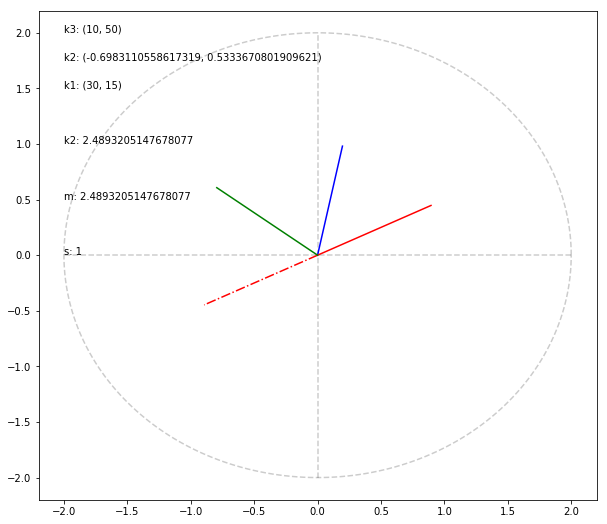

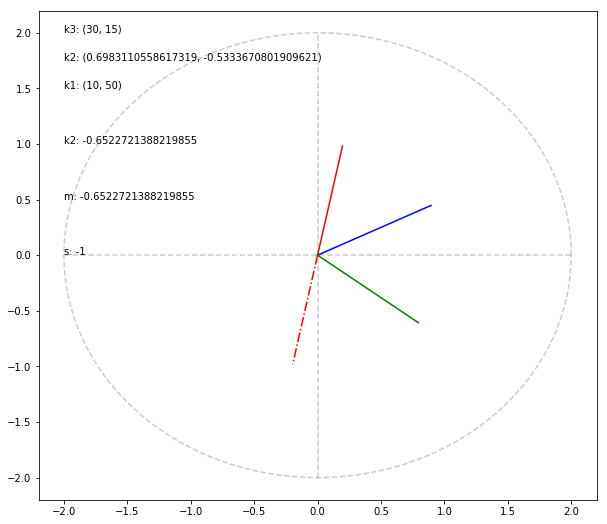

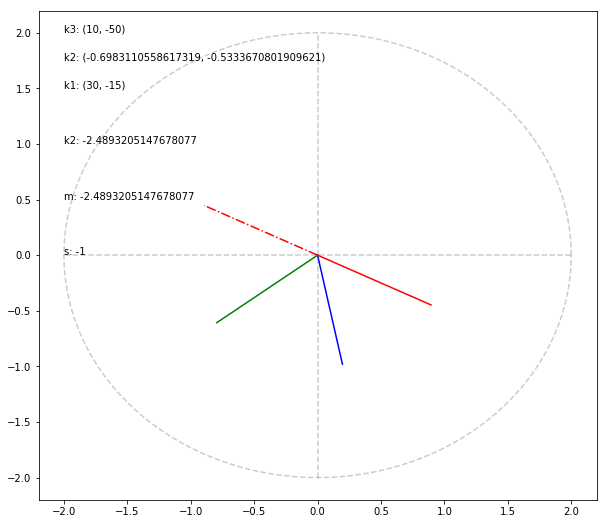

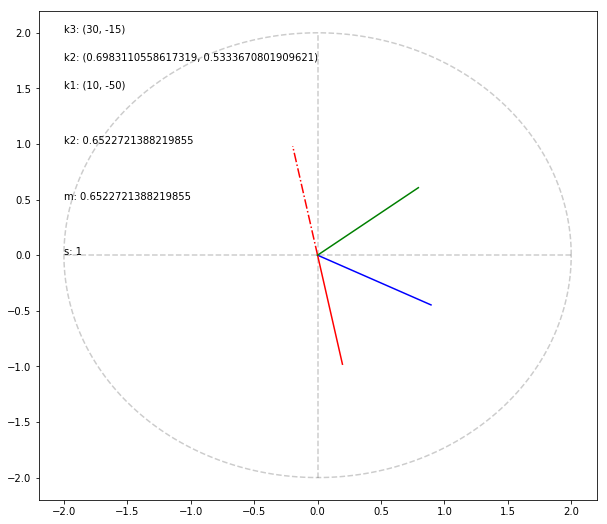

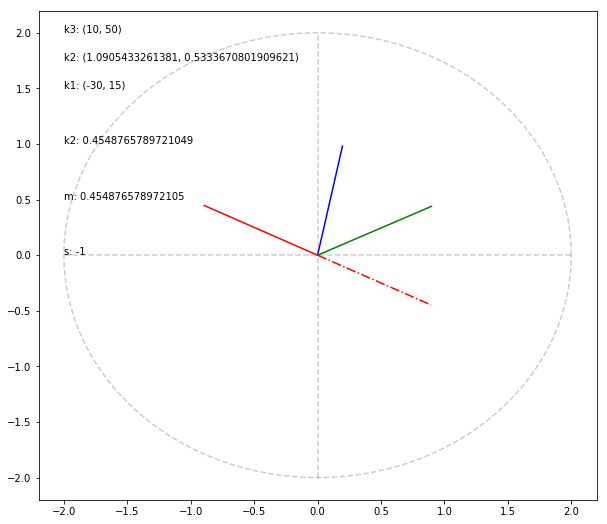

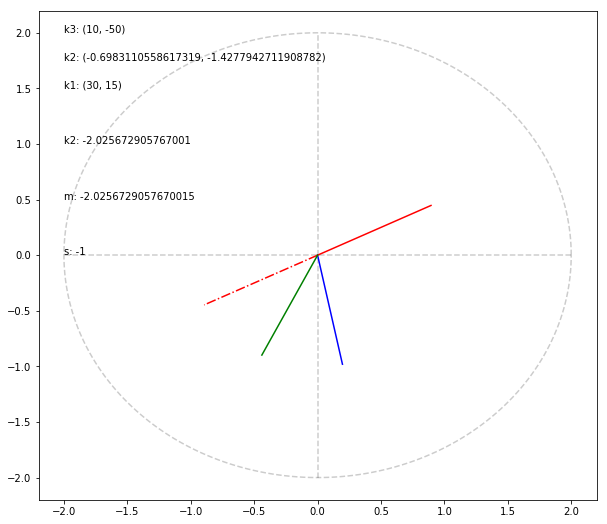

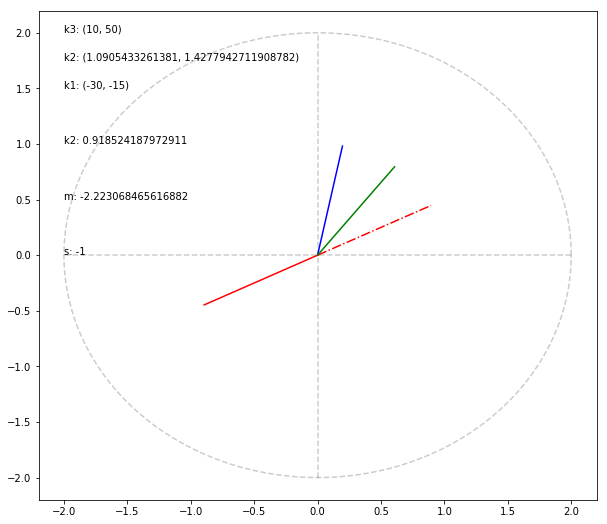

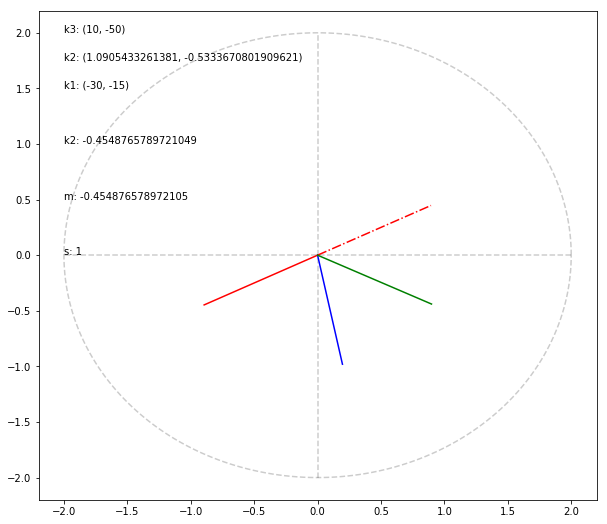

In [226]:
k3 = [10, 50]
k1 = [30, 15]
plot_triad_wave_vec(k3, k1)
plot_triad_wave_vec(k1, k3)

k3 = [10, -50]
k1 = [30, -15]
plot_triad_wave_vec(k3, k1)
plot_triad_wave_vec(k1, k3)


k3 = [10, 50]
k1 = [-30, 15]
plot_triad_wave_vec(k3, k1)

k3 = [10, -50]
k1 = [30, 15]
plot_triad_wave_vec(k3, k1)

k3 = [10, 50]
k1 = [-30, -15]
print(np.cross(k1, k3))
print(vec_angle(k3))
print(vec_angle(k1))
print(((vec_angle(k3 + vec_angle(k1))/2)))
print(((vec_angle(k3 + vec_angle(k1) + np.pi)/2)))
print(((vec_angle(k3 + vec_angle(k1) - np.pi)/2)))
print(vec_angle(np.array(k3) - np.array(k1)))
plot_triad_wave_vec(k3, k1)

k3 = [10, -50]
k1 = [-30, -15]
plot_triad_wave_vec(k3, k1)


In [231]:
k3 = [10, 50]
k1 = [-30, -15]
k3 = np.array(k3)
k3 = k3/np.linalg.norm(k3)
k1 = np.array(k1)
k1 = k1/np.linalg.norm(k1)
k2 = k3 - k1
print(k2)
print(vec_angle(k2))
print(vec_angle(k3))
print(vec_angle(k1))

[1.09054333 1.42779427]
0.918524187972911
1.373400766945016
-2.677945044588987


In [234]:
(1.373400766945016 + (-2.677945044588987) + np.pi) / 2 

0.918524187972911